## Visual Transformer

In [1]:
try:
    # one of the ways to check if our notebook is running inside google colab
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !git clone  https://github.com/gmum/ml2025-26.git
    import sys
    sys.path.append('/content/ml2025-26/lab')

Cloning into 'ml2025-26'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 127 (delta 46), reused 116 (delta 37), pack-reused 0 (from 0)
Receiving objects: 100% (127/127), 18.14 MiB | 13.08 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [18]:
import math
import torch
from torch import nn, optim

import torchvision
from torchvision.transforms import v2

from utils import save_experiment, save_checkpoint, load_experiment, visualize_images, visualize_attention

from checker import (
    expected_vit_embeddings_output,
    expected_vit_attention_head_output, expected_vit_attention_head_probs,
    expected_vit_multi_head_attention_output, expected_vit_multi_head_attention_probs,
    expected_vit_faster_multi_head_attention_output, expected_vit_faster_multi_head_attention_probs
)

### CNN vs ViT processing

```
CNN Processing:
Input → Conv(3×3) → Conv(3×3) → Conv(3×3) → ... → Global Pool → FC
        ↓           ↓           ↓
      Local        Local        Local
     (receptive field grows slowly)

ViT Processing:  
Input → Patches → Self-Attention → Self-Attention → ... → [CLS] Token → FC
                     ↓               ↓
                   Global          Global
                (immediate full-image context)
```

### ViT implementation

### Zadanie 1: PatchEmbeddings (1 pkt.)


In [3]:
class PatchEmbeddings(nn.Module):
    """
    Convert the image into patches and then project them into a vector space.
    """

    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        # Calculate the number of patches from the image size and patch size
        self.num_patches = (self.image_size // self.patch_size) ** 2
        # Create a projection layer to convert the image into patches
        # The layer projects each patch into a vector of size hidden_size
        self.projection = nn.Conv2d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x: torch.Tensor):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)
        # Create a learnable [CLS] token
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
        # Create position embeddings for the [CLS] token and the patch embeddings
        # Add 1 to the sequence length for the [CLS] token
        self.position_embeddings = nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"]))
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x: torch.Tensor):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        # Expand the [CLS] token to the batch size
        # (1, 1, hidden_size) -> (batch_size, 1, hidden_size)
        cls_tokens = self.cls_token.repeat(batch_size, 1, 1)
        # Concatenate the [CLS] token to the beginning of the input sequence and add positional position_embeddings
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.position_embeddings
        return self.dropout(x)

In [4]:
def test_embeddings():
  torch.manual_seed(0)
  embeddings = Embeddings({
      "image_size": 16,
      "patch_size": 4,
      "hidden_size": 4,
      "num_channels": 3,
      "hidden_dropout_prob": 0.0,
  })
  input_data = torch.randn(1, 3, 16, 16)
  result = embeddings(input_data)
  assert torch.allclose(result, expected_vit_embeddings_output, atol=1e-3)
  print("Passed")

test_embeddings()

Passed


### Zadanie 2: Attention (2 pkt.)


In [5]:
class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.

    """
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size

        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Project the input into query, key, and value
        # The same input is used to generate the query, key, and value,
        # so it's usually called self-attention.
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, attention_head_size)
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        # Calculate the attention:
        softmax = nn.Softmax(dim=-1)

        key_trans = torch.transpose(key, -1, -2)
        attention_probs = softmax((query @ key_trans) / (self.attention_head_size)**(1/2))

        attention_probs = self.dropout(attention_probs)
        attention_output = attention_probs @ value
        return (attention_output, attention_probs)

In [6]:
def test_attention_head():
  torch.manual_seed(0)
  attention = AttentionHead(**{
      "hidden_size": 4,
      "attention_head_size": 4,
      "dropout": 0.0,
  })
  input_data = torch.randn(1, 8, 4)
  attention_output, attention_probs = attention(input_data)

  assert torch.allclose(attention_output, expected_vit_attention_head_output, atol=1e-3)
  assert torch.allclose(attention_probs, expected_vit_attention_head_probs, atol=1e-3)
  print("Passed")

test_attention_head()

Passed


Zadanie 3: MultiHeadAttention (1 pkt.)

In [7]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module.
    This module is used in the TransformerEncoder module.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a list of attention heads
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,
                self.attention_head_size,
                config["attention_probs_dropout_prob"],
                self.qkv_bias
            )
            self.heads.append(head)
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        # Calculate the attention output for each attention head
        attention_outputs = [head(x) for head in self.heads]
        # Concatenate the attention outputs from each attention head
        attention_output = torch.cat([output for output, _probs in attention_outputs], dim=-1)
        # Project the concatenated attention output back to the hidden size
        attention_output = self.output_projection(attention_output)

        attention_output = self.output_dropout(attention_output)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)

In [8]:
def test_multi_head_attention_head():
  torch.manual_seed(0)
  attention = MultiHeadAttention({
      "hidden_size": 6,
      "num_attention_heads": 2,
      "attention_probs_dropout_prob": 0.0,
      "hidden_dropout_prob": 0.0,
      "qkv_bias": True,
  })
  input_data = torch.randn(1, 8, 6)
  attention_output, attention_probs = attention(input_data, output_attentions=True)
  assert torch.allclose(attention_output, expected_vit_multi_head_attention_output, atol=1e-3)
  assert torch.allclose(attention_probs, expected_vit_multi_head_attention_probs, atol=1e-3)
  print("Passed")

test_multi_head_attention_head()

Passed


### Zadanie 4. FasterMultiHeadAttention (3 pkt.)

In [9]:
class FasterMultiHeadAttention(nn.Module):
    """
    Multi-head attention module with some optimizations.
    All the heads are processed simultaneously with merged query, key, and value projections.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a linear layer to project the query, key, and value
        self.qkv_projection = nn.Linear(self.hidden_size, self.all_head_size * 3, bias=self.qkv_bias)
        self.attn_dropout = nn.Dropout(config["attention_probs_dropout_prob"])
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        # Project the query, key, and value
        qkv = self.qkv_projection(x)
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, all_head_size * 3)
        # Split the projected query, key, and value into query, key, and value
        # (batch_size, sequence_length, all_head_size * 3) -> (batch_size, sequence_length, all_head_size)
        query, key, value = torch.chunk(qkv, 3, dim=-1)
        # Resize the query, key, and value to (batch_size, num_attention_heads, sequence_length, attention_head_size)
        batch_size, sequence_length, _ = query.size()
        query = query.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        key = key.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        value = value.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)

        # Calculate the attention:
        softmax = nn.Softmax(dim=-1)

        key_trans = torch.transpose(key, -1, -2)
        attention_probs = softmax((query @ key_trans) / (self.attention_head_size)**(1/2))

        attention_output = attention_probs @ value
        # Resize the attention output
        # from (batch_size, num_attention_heads, sequence_length, attention_head_size)
        # To (batch_size, sequence_length, all_head_size)
        attention_output = attention_output.transpose(1, 2).reshape(batch_size, sequence_length, self.all_head_size)

        # Project the attention output back to the hidden size
        attention_output = self.output_projection(attention_output)

        attention_output = self.output_dropout(attention_output)
        if not output_attentions:
            return (attention_output, None)
        else:
            return (attention_output, attention_probs)

In [10]:
def test_faster_multi_head_attention_head():
  torch.manual_seed(0)
  attention = FasterMultiHeadAttention({
      "hidden_size": 6,
      "num_attention_heads": 2,
      "attention_probs_dropout_prob": 0.0,
      "hidden_dropout_prob": 0.0,
      "qkv_bias": True,
  })
  input_data = torch.randn(1, 8, 6)
  attention_output, attention_probs = attention(input_data, output_attentions=True)
  assert torch.allclose(attention_output, expected_vit_faster_multi_head_attention_output, atol=1e-3)
  assert torch.allclose(attention_probs, expected_vit_faster_multi_head_attention_probs, atol=1e-3)
  print("Passed")

test_faster_multi_head_attention_head()

Passed


### ViT definition

In [11]:
class MLP(nn.Module):
    """
    A multi-layer perceptron module.
    """

    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.activation = nn.GELU(approximate='tanh')
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    """
    A single transformer block.
    """

    def __init__(self, config):
        super().__init__()
        self.use_faster_attention = config.get("use_faster_attention", False)
        if self.use_faster_attention:
            self.attention = FasterMultiHeadAttention(config)
        else:
            self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

    def forward(self, x, output_attentions=False):
        # Self-attention
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        # Skip connection
        x = x + attention_output
        # Feed-forward network
        mlp_output = self.mlp(self.layernorm_2(x))
        # Skip connection
        x = x + mlp_output
        # Return the transformer block's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)

class Encoder(nn.Module):
    """
    The transformer encoder module.
    """

    def __init__(self, config):
        super().__init__()
        # Create a list of transformer blocks
        self.blocks = nn.ModuleList([])
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        # Calculate the transformer block's output for each block
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        # Return the encoder's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)

class ViTForClassfication(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]
        # Create the embedding module
        self.embedding = Embeddings(config)
        # Create the transformer encoder module
        self.encoder = Encoder(config)
        # Create a linear layer to project the encoder's output to the number of classes
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)
        # Initialize the weights
        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):
        # Calculate the embedding output
        embedding_output = self.embedding(x)
        # Calculate the encoder's output
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
        # Calculate the logits, take the [CLS] token's output as features for classification
        logits = self.classifier(encoder_output[:, 0, :])
        # Return the logits and the attention probabilities (optional)
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)

### Data preparation

In [12]:
def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):
    train_transform = v2.Compose([
        v2.ToTensor(),
        v2.ColorJitter(
          brightness=0.2,
          contrast=0.2,
          saturation=0.2,
          hue=0.1
    ),
        v2.RandomErasing(p=0.25, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random'),
        v2.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.247, 0.243, 0.261]
        ),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomCrop(size=32, padding=4)
        # RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)
        ])

    trainset = torchvision.datasets.CIFAR10(root='.', train=True,
                                            download=True, transform=train_transform)
    if train_sample_size is not None:
        # Randomly sample a subset of the training set
        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)



    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)

    test_transform = v2.Compose(
        [v2.ToTensor(),
        v2.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.247, 0.243, 0.261]
            )
        ])

    testset = torchvision.datasets.CIFAR10(root='.', train=False,
                                        download=True, transform=test_transform)
    if test_sample_size is not None:
        # Randomly sample a subset of the test set
        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)

    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    return trainloader, testloader, classes

#### Training config

In [13]:
from tqdm import tqdm

class Trainer:
    """
    The simple trainer.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device, scheduler=None):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device
        if scheduler is not None:
          self.scheduler = scheduler

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs.
        """
        # Keep track of the losses and accuracies
        train_losses, test_losses, accuracies = [], [], []
        # Train the model
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.exp_name, self.model, i+1)
        # Save the experiment
        save_experiment(self.exp_name, config, self.model, train_losses, test_losses, accuracies)

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        for batch in tqdm(trainloader):
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            # Zero the gradients
            self.optimizer.zero_grad()
            # Calculate the loss
            loss = self.loss_fn(self.model(images)[0], labels)
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        if self.scheduler is not None:
            self.scheduler.step()
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in tqdm(testloader):
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits, _ = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss

### Zadanie 5. Train ViT (3 pkt.)

Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym.


In [16]:
exp_name = 'vit-with-10-epochs'
batch_size = 256
epochs = 50
lr = 1e-3
save_model_every = 5


device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 256,
    "num_hidden_layers": 6,
    "num_attention_heads": 8,
    "intermediate_size": 4 * 256, # 4 * hidden_size
    "hidden_dropout_prob": 0.1,
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True, # if task 4 is done
}

# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0



# Training parameters
save_model_every_n_epochs = save_model_every
# Load the CIFAR10 dataset
trainloader, testloader, _ = prepare_data(batch_size=batch_size)
# Create the model, optimizer, loss function and trainer
model = ViTForClassfication(config)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
loss_fn = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device, scheduler=scheduler)
trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every_n_epochs)



100%|██████████| 40/40 [00:03<00:00, 11.91it/s]


Epoch: 1, Train loss: 1.9100, Test loss: 1.6323, Accuracy: 0.3997


100%|██████████| 40/40 [00:03<00:00, 10.54it/s]


Epoch: 2, Train loss: 1.6422, Test loss: 1.4888, Accuracy: 0.4523


100%|██████████| 40/40 [00:03<00:00, 13.14it/s]


Epoch: 3, Train loss: 1.5111, Test loss: 1.3600, Accuracy: 0.5094


100%|██████████| 40/40 [00:03<00:00, 10.76it/s]


Epoch: 4, Train loss: 1.4464, Test loss: 1.3367, Accuracy: 0.5236


100%|██████████| 40/40 [00:03<00:00, 12.99it/s]


Epoch: 5, Train loss: 1.3980, Test loss: 1.3330, Accuracy: 0.5234
	Save checkpoint at epoch 5


100%|██████████| 40/40 [00:03<00:00, 12.90it/s]


Epoch: 6, Train loss: 1.3680, Test loss: 1.2161, Accuracy: 0.5533


100%|██████████| 40/40 [00:03<00:00, 12.99it/s]


Epoch: 7, Train loss: 1.3334, Test loss: 1.1915, Accuracy: 0.5716


100%|██████████| 40/40 [00:03<00:00, 12.96it/s]


Epoch: 8, Train loss: 1.2994, Test loss: 1.2144, Accuracy: 0.5665


100%|██████████| 40/40 [00:03<00:00, 11.33it/s]


Epoch: 9, Train loss: 1.2801, Test loss: 1.2325, Accuracy: 0.5655


100%|██████████| 40/40 [00:03<00:00, 12.97it/s]


Epoch: 10, Train loss: 1.2514, Test loss: 1.0838, Accuracy: 0.6138
	Save checkpoint at epoch 10


100%|██████████| 40/40 [00:03<00:00, 12.00it/s]


Epoch: 11, Train loss: 1.2208, Test loss: 1.1157, Accuracy: 0.6031


100%|██████████| 40/40 [00:03<00:00, 13.05it/s]


Epoch: 12, Train loss: 1.1889, Test loss: 1.0878, Accuracy: 0.6131


100%|██████████| 40/40 [00:03<00:00, 10.87it/s]


Epoch: 13, Train loss: 1.1771, Test loss: 1.0774, Accuracy: 0.6164


100%|██████████| 40/40 [00:03<00:00, 12.95it/s]


Epoch: 14, Train loss: 1.1450, Test loss: 1.0363, Accuracy: 0.6267


100%|██████████| 40/40 [00:03<00:00, 12.76it/s]


Epoch: 15, Train loss: 1.1152, Test loss: 1.0808, Accuracy: 0.6121
	Save checkpoint at epoch 15


100%|██████████| 40/40 [00:03<00:00, 12.76it/s]


Epoch: 16, Train loss: 1.1041, Test loss: 0.9741, Accuracy: 0.6505


100%|██████████| 40/40 [00:03<00:00, 13.01it/s]


Epoch: 17, Train loss: 1.0797, Test loss: 0.9532, Accuracy: 0.6624


100%|██████████| 40/40 [00:03<00:00, 10.69it/s]


Epoch: 18, Train loss: 1.0627, Test loss: 0.9602, Accuracy: 0.6585


100%|██████████| 40/40 [00:03<00:00, 13.07it/s]


Epoch: 19, Train loss: 1.0501, Test loss: 0.9252, Accuracy: 0.6706


100%|██████████| 40/40 [00:03<00:00, 12.75it/s]


Epoch: 20, Train loss: 1.0288, Test loss: 0.9835, Accuracy: 0.6490
	Save checkpoint at epoch 20


100%|██████████| 40/40 [00:03<00:00, 10.84it/s]


Epoch: 21, Train loss: 1.0073, Test loss: 0.9025, Accuracy: 0.6807


100%|██████████| 40/40 [00:03<00:00, 12.92it/s]


Epoch: 22, Train loss: 0.9930, Test loss: 0.9018, Accuracy: 0.6776


100%|██████████| 40/40 [00:03<00:00, 12.38it/s]


Epoch: 23, Train loss: 0.9732, Test loss: 0.8803, Accuracy: 0.6921


100%|██████████| 40/40 [00:03<00:00, 12.96it/s]


Epoch: 24, Train loss: 0.9585, Test loss: 0.8909, Accuracy: 0.6921


100%|██████████| 40/40 [00:03<00:00, 13.03it/s]


Epoch: 25, Train loss: 0.9432, Test loss: 0.8347, Accuracy: 0.6998
	Save checkpoint at epoch 25


100%|██████████| 40/40 [00:03<00:00, 10.41it/s]


Epoch: 26, Train loss: 0.9327, Test loss: 0.8500, Accuracy: 0.6999


100%|██████████| 40/40 [00:03<00:00, 13.01it/s]


Epoch: 27, Train loss: 0.9129, Test loss: 0.8271, Accuracy: 0.7059


100%|██████████| 40/40 [00:03<00:00, 12.05it/s]


Epoch: 28, Train loss: 0.8935, Test loss: 0.8525, Accuracy: 0.7045


100%|██████████| 40/40 [00:03<00:00, 13.14it/s]


Epoch: 29, Train loss: 0.8884, Test loss: 0.8377, Accuracy: 0.7061


100%|██████████| 40/40 [00:03<00:00, 13.10it/s]


Epoch: 30, Train loss: 0.8717, Test loss: 0.8357, Accuracy: 0.7026
	Save checkpoint at epoch 30


100%|██████████| 40/40 [00:03<00:00, 12.59it/s]


Epoch: 31, Train loss: 0.8592, Test loss: 0.8632, Accuracy: 0.7059


100%|██████████| 40/40 [00:03<00:00, 13.09it/s]


Epoch: 32, Train loss: 0.8414, Test loss: 0.7722, Accuracy: 0.7282


100%|██████████| 40/40 [00:03<00:00, 10.64it/s]


Epoch: 33, Train loss: 0.8321, Test loss: 0.7862, Accuracy: 0.7213


100%|██████████| 40/40 [00:03<00:00, 13.08it/s]


Epoch: 34, Train loss: 0.8155, Test loss: 0.7723, Accuracy: 0.7316


100%|██████████| 40/40 [00:03<00:00, 10.77it/s]


Epoch: 35, Train loss: 0.8029, Test loss: 0.7477, Accuracy: 0.7396
	Save checkpoint at epoch 35


100%|██████████| 40/40 [00:03<00:00, 13.00it/s]


Epoch: 36, Train loss: 0.7989, Test loss: 0.7296, Accuracy: 0.7495


100%|██████████| 40/40 [00:03<00:00, 10.90it/s]


Epoch: 37, Train loss: 0.7844, Test loss: 0.7630, Accuracy: 0.7453


100%|██████████| 40/40 [00:03<00:00, 13.01it/s]


Epoch: 38, Train loss: 0.7701, Test loss: 0.7192, Accuracy: 0.7535


100%|██████████| 40/40 [00:03<00:00, 11.25it/s]


Epoch: 39, Train loss: 0.7598, Test loss: 0.7094, Accuracy: 0.7565


100%|██████████| 40/40 [00:03<00:00, 13.04it/s]


Epoch: 40, Train loss: 0.7457, Test loss: 0.7314, Accuracy: 0.7468
	Save checkpoint at epoch 40


100%|██████████| 40/40 [00:03<00:00, 11.68it/s]


Epoch: 41, Train loss: 0.7352, Test loss: 0.7074, Accuracy: 0.7555


100%|██████████| 40/40 [00:03<00:00, 13.00it/s]


Epoch: 42, Train loss: 0.7321, Test loss: 0.6885, Accuracy: 0.7636


100%|██████████| 40/40 [00:03<00:00, 13.02it/s]


Epoch: 43, Train loss: 0.7096, Test loss: 0.6870, Accuracy: 0.7638


100%|██████████| 40/40 [00:03<00:00, 13.16it/s]


Epoch: 44, Train loss: 0.7083, Test loss: 0.6903, Accuracy: 0.7597


100%|██████████| 40/40 [00:03<00:00, 13.18it/s]


Epoch: 45, Train loss: 0.6952, Test loss: 0.6902, Accuracy: 0.7670
	Save checkpoint at epoch 45


100%|██████████| 40/40 [00:03<00:00, 13.10it/s]


Epoch: 46, Train loss: 0.6859, Test loss: 0.7411, Accuracy: 0.7481


100%|██████████| 40/40 [00:03<00:00, 13.13it/s]


Epoch: 47, Train loss: 0.6737, Test loss: 0.6575, Accuracy: 0.7757


100%|██████████| 40/40 [00:03<00:00, 12.43it/s]


Epoch: 48, Train loss: 0.6665, Test loss: 0.6695, Accuracy: 0.7723


100%|██████████| 40/40 [00:03<00:00, 13.09it/s]


Epoch: 49, Train loss: 0.6560, Test loss: 0.6700, Accuracy: 0.7733


100%|██████████| 40/40 [00:03<00:00, 13.05it/s]


Epoch: 50, Train loss: 0.6427, Test loss: 0.6881, Accuracy: 0.7686


In [23]:
import os
import json

print(f"Continuing training for experiment '{exp_name}' for an additional 50 epochs.")


def load_experiment(experiment_name, model_cls, checkpoint_name="model_final.pt", base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    # Load the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'r') as f:
        config = json.load(f)
    # Load the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    test_losses = data['test_losses']
    accuracies = data['accuracies']
    # Load the model
    model = model_cls(config)
    cpfile = os.path.join(outdir, checkpoint_name)
    model.load_state_dict(torch.load(cpfile))
    return config, model, train_losses, test_losses, accuracies


_, model_loaded, _, _, _ = load_experiment(exp_name, ViTForClassfication)
continued_exp_name = 'vit-additional-50-epochs'
model_loaded.to(device)
continued_lr = 1e-4
additional_epochs = 50

optimizer_continued = optim.AdamW(model_loaded.parameters(), lr=continued_lr, weight_decay=5e-2)
scheduler_continued = optim.lr_scheduler.CosineAnnealingLR(optimizer_continued, T_max=additional_epochs)
trainer_continued = Trainer(model_loaded, optimizer_continued, loss_fn, continued_exp_name, device=device, scheduler=scheduler_continued)

print(f"Starting additional training for {additional_epochs} epochs.")
trainer_continued.train(trainloader, testloader, additional_epochs, save_model_every_n_epochs=save_model_every)

print("Additional training complete.")

Continuing training for experiment 'vit-with-10-epochs' for an additional 50 epochs.
Starting additional training for 50 epochs.


100%|██████████| 40/40 [00:03<00:00, 13.28it/s]


Epoch: 1, Train loss: 0.5280, Test loss: 0.5942, Accuracy: 0.7990


100%|██████████| 40/40 [00:03<00:00, 10.37it/s]


Epoch: 2, Train loss: 0.4901, Test loss: 0.5768, Accuracy: 0.8057


100%|██████████| 40/40 [00:03<00:00, 12.98it/s]


Epoch: 3, Train loss: 0.4725, Test loss: 0.5794, Accuracy: 0.8079


100%|██████████| 40/40 [00:03<00:00, 12.92it/s]


Epoch: 4, Train loss: 0.4572, Test loss: 0.5702, Accuracy: 0.8110


100%|██████████| 40/40 [00:03<00:00, 12.78it/s]


Epoch: 5, Train loss: 0.4538, Test loss: 0.5645, Accuracy: 0.8145
	Save checkpoint at epoch 5


100%|██████████| 40/40 [00:03<00:00, 13.02it/s]


Epoch: 6, Train loss: 0.4410, Test loss: 0.5685, Accuracy: 0.8146


100%|██████████| 40/40 [00:03<00:00, 11.45it/s]


Epoch: 7, Train loss: 0.4374, Test loss: 0.5706, Accuracy: 0.8138


100%|██████████| 40/40 [00:03<00:00, 13.00it/s]


Epoch: 8, Train loss: 0.4299, Test loss: 0.5710, Accuracy: 0.8141


100%|██████████| 40/40 [00:03<00:00, 10.91it/s]


Epoch: 9, Train loss: 0.4203, Test loss: 0.5676, Accuracy: 0.8147


100%|██████████| 40/40 [00:03<00:00, 12.91it/s]


Epoch: 10, Train loss: 0.4161, Test loss: 0.5716, Accuracy: 0.8159
	Save checkpoint at epoch 10


100%|██████████| 40/40 [00:03<00:00, 10.57it/s]


Epoch: 11, Train loss: 0.4089, Test loss: 0.5691, Accuracy: 0.8155


100%|██████████| 40/40 [00:03<00:00, 12.94it/s]


Epoch: 12, Train loss: 0.4106, Test loss: 0.5633, Accuracy: 0.8166


100%|██████████| 40/40 [00:03<00:00, 11.12it/s]


Epoch: 13, Train loss: 0.4021, Test loss: 0.5684, Accuracy: 0.8187


100%|██████████| 40/40 [00:03<00:00, 12.86it/s]


Epoch: 14, Train loss: 0.3992, Test loss: 0.5663, Accuracy: 0.8202


100%|██████████| 40/40 [00:03<00:00, 12.97it/s]


Epoch: 15, Train loss: 0.3915, Test loss: 0.5578, Accuracy: 0.8226
	Save checkpoint at epoch 15


100%|██████████| 40/40 [00:03<00:00, 12.97it/s]


Epoch: 16, Train loss: 0.3922, Test loss: 0.5693, Accuracy: 0.8177


100%|██████████| 40/40 [00:03<00:00, 13.03it/s]


Epoch: 17, Train loss: 0.3842, Test loss: 0.5701, Accuracy: 0.8202


100%|██████████| 40/40 [00:03<00:00, 12.60it/s]


Epoch: 18, Train loss: 0.3830, Test loss: 0.5657, Accuracy: 0.8194


100%|██████████| 40/40 [00:03<00:00, 12.93it/s]


Epoch: 19, Train loss: 0.3768, Test loss: 0.5632, Accuracy: 0.8221


100%|██████████| 40/40 [00:03<00:00, 11.15it/s]


Epoch: 20, Train loss: 0.3756, Test loss: 0.5642, Accuracy: 0.8226
	Save checkpoint at epoch 20


100%|██████████| 40/40 [00:03<00:00, 13.14it/s]


Epoch: 21, Train loss: 0.3700, Test loss: 0.5733, Accuracy: 0.8226


100%|██████████| 40/40 [00:03<00:00, 11.45it/s]


Epoch: 22, Train loss: 0.3668, Test loss: 0.5662, Accuracy: 0.8237


100%|██████████| 40/40 [00:03<00:00, 13.14it/s]


Epoch: 23, Train loss: 0.3644, Test loss: 0.5837, Accuracy: 0.8190


100%|██████████| 40/40 [00:03<00:00, 11.87it/s]


Epoch: 24, Train loss: 0.3635, Test loss: 0.5637, Accuracy: 0.8262


100%|██████████| 40/40 [00:03<00:00, 12.95it/s]


Epoch: 25, Train loss: 0.3581, Test loss: 0.5687, Accuracy: 0.8233
	Save checkpoint at epoch 25


100%|██████████| 40/40 [00:03<00:00, 13.02it/s]


Epoch: 26, Train loss: 0.3582, Test loss: 0.5834, Accuracy: 0.8161


100%|██████████| 40/40 [00:03<00:00, 13.10it/s]


Epoch: 27, Train loss: 0.3469, Test loss: 0.5823, Accuracy: 0.8212


100%|██████████| 40/40 [00:03<00:00, 11.86it/s]


Epoch: 28, Train loss: 0.3473, Test loss: 0.5820, Accuracy: 0.8188


100%|██████████| 40/40 [00:03<00:00, 13.09it/s]


Epoch: 29, Train loss: 0.3400, Test loss: 0.5775, Accuracy: 0.8205


100%|██████████| 40/40 [00:03<00:00, 11.42it/s]


Epoch: 30, Train loss: 0.3427, Test loss: 0.5781, Accuracy: 0.8240
	Save checkpoint at epoch 30


100%|██████████| 40/40 [00:03<00:00, 12.76it/s]


Epoch: 31, Train loss: 0.3423, Test loss: 0.5771, Accuracy: 0.8212


100%|██████████| 40/40 [00:03<00:00, 11.09it/s]


Epoch: 32, Train loss: 0.3373, Test loss: 0.5804, Accuracy: 0.8203


100%|██████████| 40/40 [00:03<00:00, 13.06it/s]


Epoch: 33, Train loss: 0.3309, Test loss: 0.5781, Accuracy: 0.8227


100%|██████████| 40/40 [00:03<00:00, 11.90it/s]


Epoch: 34, Train loss: 0.3323, Test loss: 0.5808, Accuracy: 0.8230


100%|██████████| 40/40 [00:03<00:00, 12.92it/s]


Epoch: 35, Train loss: 0.3267, Test loss: 0.5849, Accuracy: 0.8211
	Save checkpoint at epoch 35


100%|██████████| 40/40 [00:03<00:00, 11.31it/s]


Epoch: 36, Train loss: 0.3259, Test loss: 0.5807, Accuracy: 0.8252


100%|██████████| 40/40 [00:03<00:00, 12.92it/s]


Epoch: 37, Train loss: 0.3186, Test loss: 0.5878, Accuracy: 0.8236


100%|██████████| 40/40 [00:03<00:00, 10.88it/s]


Epoch: 38, Train loss: 0.3156, Test loss: 0.5847, Accuracy: 0.8232


100%|██████████| 40/40 [00:03<00:00, 12.89it/s]


Epoch: 39, Train loss: 0.3127, Test loss: 0.5918, Accuracy: 0.8229


100%|██████████| 40/40 [00:03<00:00, 13.05it/s]


Epoch: 40, Train loss: 0.3102, Test loss: 0.5937, Accuracy: 0.8228
	Save checkpoint at epoch 40


100%|██████████| 40/40 [00:03<00:00, 12.98it/s]


Epoch: 41, Train loss: 0.3099, Test loss: 0.6009, Accuracy: 0.8193


100%|██████████| 40/40 [00:03<00:00, 12.21it/s]


Epoch: 42, Train loss: 0.3080, Test loss: 0.5930, Accuracy: 0.8234


100%|██████████| 40/40 [00:03<00:00, 13.11it/s]


Epoch: 43, Train loss: 0.3056, Test loss: 0.5859, Accuracy: 0.8203


100%|██████████| 40/40 [00:03<00:00, 12.25it/s]


Epoch: 44, Train loss: 0.2986, Test loss: 0.5942, Accuracy: 0.8228


100%|██████████| 40/40 [00:03<00:00, 13.06it/s]


Epoch: 45, Train loss: 0.2978, Test loss: 0.5970, Accuracy: 0.8232
	Save checkpoint at epoch 45


100%|██████████| 40/40 [00:03<00:00, 13.02it/s]


Epoch: 46, Train loss: 0.2963, Test loss: 0.5951, Accuracy: 0.8233


100%|██████████| 40/40 [00:03<00:00, 13.12it/s]


Epoch: 47, Train loss: 0.2892, Test loss: 0.6061, Accuracy: 0.8213


100%|██████████| 40/40 [00:03<00:00, 11.08it/s]


Epoch: 48, Train loss: 0.2935, Test loss: 0.5988, Accuracy: 0.8220


100%|██████████| 40/40 [00:03<00:00, 13.08it/s]


Epoch: 49, Train loss: 0.2914, Test loss: 0.6068, Accuracy: 0.8245


100%|██████████| 40/40 [00:03<00:00, 12.74it/s]

Epoch: 50, Train loss: 0.2892, Test loss: 0.6134, Accuracy: 0.8242
Additional training complete.


### Attention Visualization

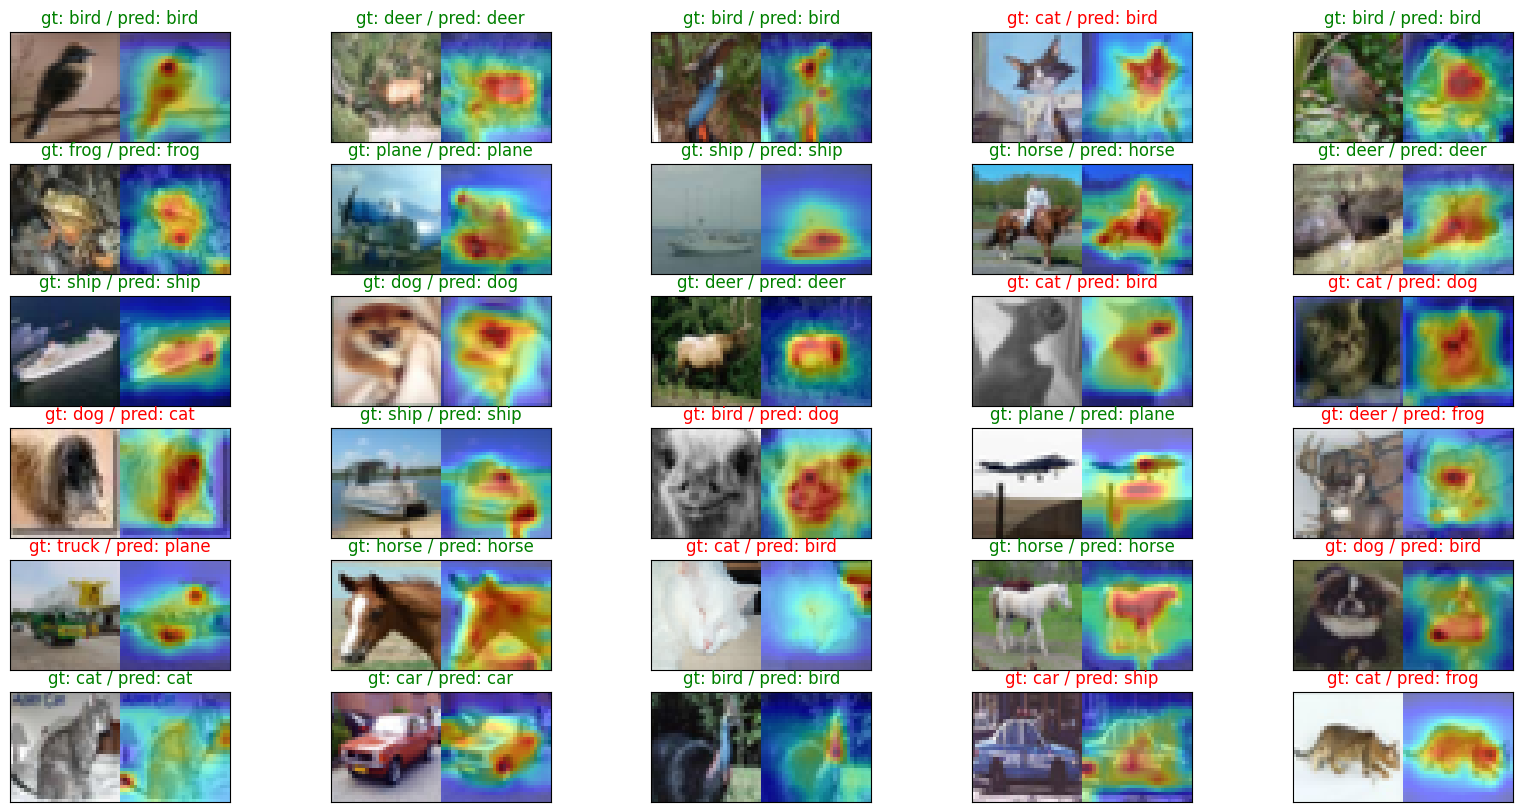

In [24]:
visualize_attention(model, "attention.png")